# Plot the light curves and allan variance plots for K2-28b and K2-100b

In [2]:
# ---------- Graphics ------------
# matplotlib
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=0.5,rc={"font":"helvetica"});
sns.set_style("white"); #sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.weight'] = "normal"
rcParams["axes.formatter.useoffset"] = False
rcParams['xtick.major.width']=1
rcParams['xtick.major.size']=4
rcParams['xtick.minor.width']=0.5
rcParams['xtick.minor.size']=2
rcParams['xtick.direction'] = "in"
rcParams['ytick.direction'] = "in"
rcParams['ytick.major.width']=1
rcParams['ytick.major.size']=4
rcParams['ytick.minor.width']=0.5
rcParams['ytick.minor.size']=2

from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

import getpass
# Remove gks paths (not needed for anyone else)
if getpass.getuser()=="gks":
    try:
        sys.path.remove("/Users/gks/Dropbox/mypylib/notebooks/GIT/transitMCMC/src")
        sys.path.remove("/Users/gks/Dropbox/mypylib")
        sys.path.append("/Users/gks/programs/MCcubed2/MCcubed/")
    except Exception as e:
        print(e)
        print("Paths already removed")
        
# *****users must set this*******
# Add path to mc3 
sys.path.append("/Users/Sophie/git/MCcubed/")
sys.path.append("../src/")
import MCcubed as mc3 

In [3]:
from priors import PriorSet, UP, NP, JP
import trf
import pyde
import mcmc_utils
from exotk.utils.likelihood import ll_normal_ev_py, ll_normal_es, ll_normal_ev
import batman
import math
import epicblsmulti
import k2help
import utils
import allanvariancemc_modified 

In [ ]:
# Read the Ground and K2 data for k2-28b and k2-100b
df_ground = pd.read_csv("../data/k2_28b/K2_data_k2_28b_for_plotting_ground.csv",sep=",",header=0)
df_k2 = pd.read_csv("../data/k2_28b/K2_data_k2_28b_for_plotting_k2.csv",sep=",",header=0)

df_ground_k2_100b = pd.read_csv("../data/k2_100b/K2_data_k2_100b_for_plotting_ground.csv",sep=",",header=0)
df_k2_k2_100b = pd.read_csv("../data/k2_100b/K2_data_k2_100b_for_plotting_k2.csv",sep=",",header=0)

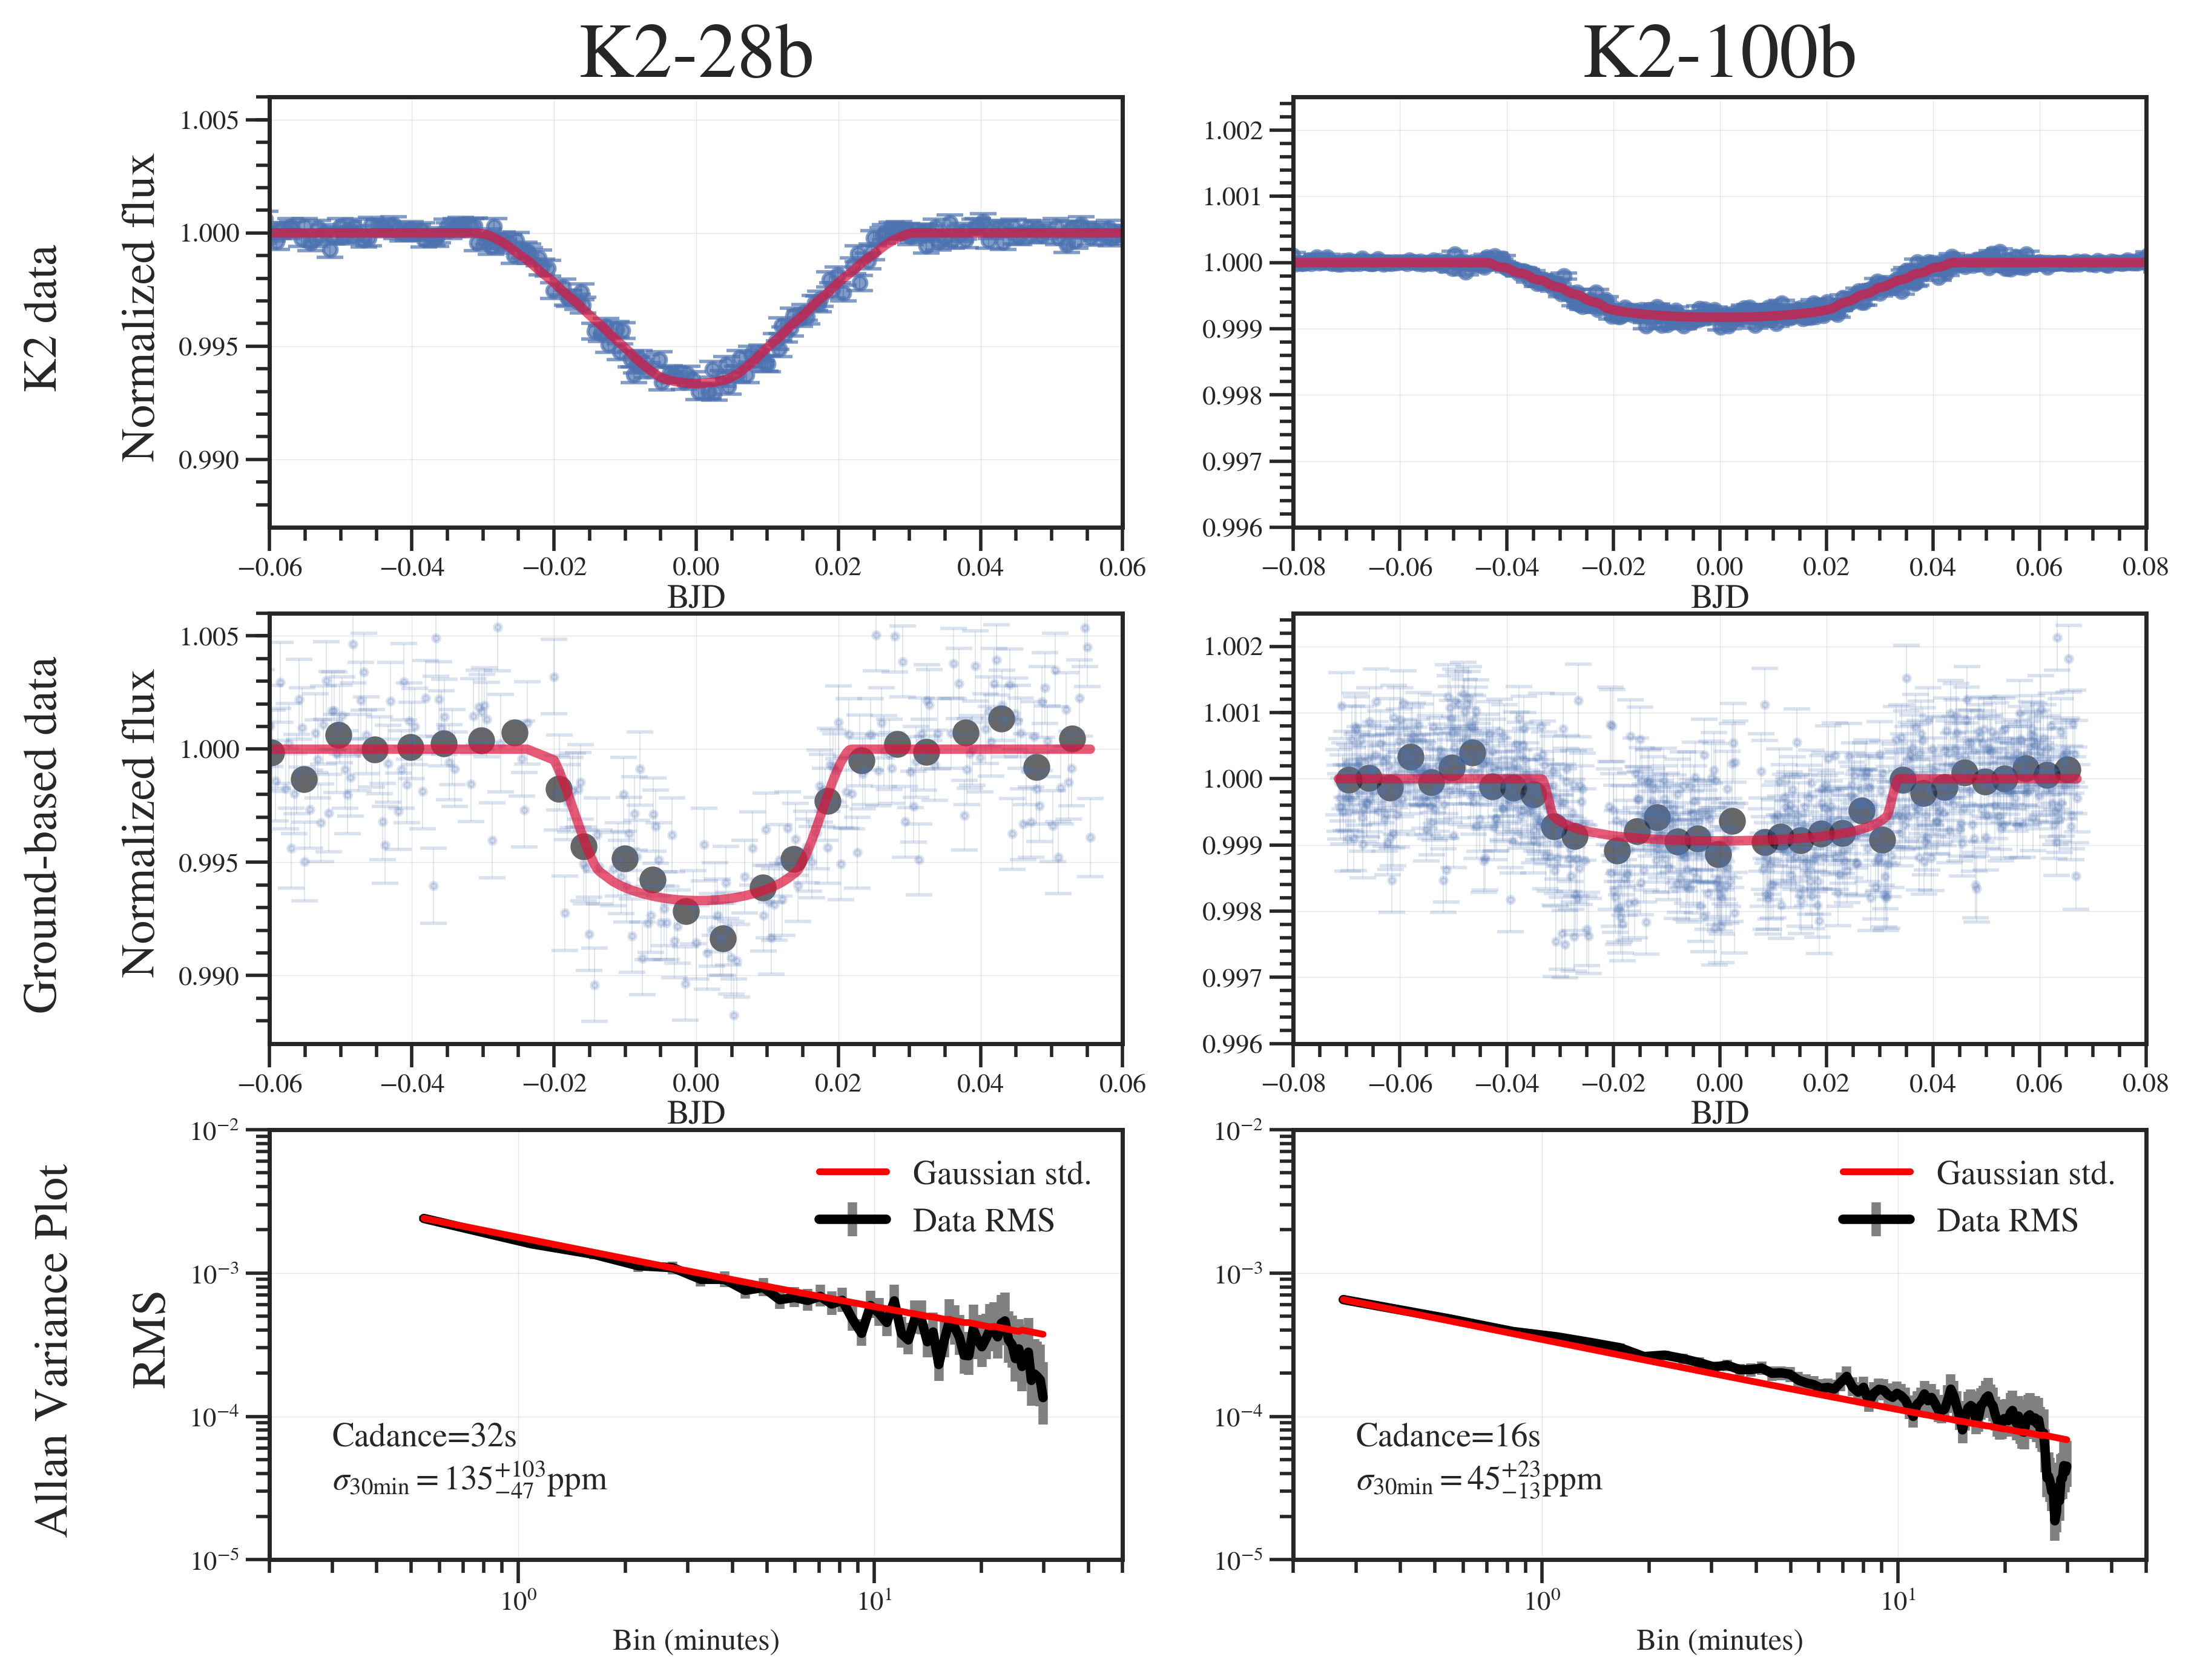

In [11]:
import plot_transits
# create a 6 panel plot
fig, axx = plt.subplots(nrows=3,ncols=2,figsize=(10,8))
(ax,bx),(dx,ex),(gx,hx) = axx

# Obtain period and cadance values from joint analysis
p_k2_28b = 2.26050002261
p_k2_100b= 1.6739026

cadance_k2_28b = 32.5728267431
cadance_k2_100b= 16.5888056159

#k2-28b light curve and allan variance plot
k2_28_t0 = df_ground['xmodel_ground'][np.argmin(df_ground['ymodel_ground'])]

plot_transits.plot_transit_with_model(df_k2['phase_fold_time_k2']*p_k2_28b,
                        df_k2['phase_fold_scaled_flux_k2'],
                        df_k2['scaled_error_k2'],
                        yresidual=None,
                        xmodel=df_k2['xmodel_k2']*p_k2_28b,
                        ymodel=df_k2['ymodel_k2'],ax=ax)
plot_transits.plot_transit_with_model(df_ground['time_ground']-k2_28_t0,
                        df_ground['scaled_flux_ground'],
                        df_ground['scaled_error_ground'],
                        yresidual=None,
                        xmodel=df_ground['xmodel_ground']-k2_28_t0,
                        ymodel=df_ground['ymodel_ground'],
                        offset=0.975,ax=dx,alpha=0.2,markersize=2.)
df_k2_28b = utils.bin_data(df_ground['time_ground']-k2_28_t0,df_ground['scaled_flux_ground'],int(5.*60./cadance_k2_28b))
dx.plot(df_k2_28b.x,df_k2_28b.y,lw=0,marker="o",markersize=8,alpha=0.6,color="black",zorder=1)

# (Sinusoidal) time-correlated signal:
red = np.array(df_ground['yresidual_ground'])
# Generate residuals signal:
N = len(red)
# White-noise signal:
white = np.random.normal(0, 5, N)
# Compute the residuals rms-vs-binsize:
maxbins = int(1800/cadance_k2_28b)
rms, rmslo, rmshi, stderr, binsz = mc3.rednoise.binrms(red, maxbins)
gx.errorbar(binsz*cadance_k2_28b/60., rms, yerr=[rmslo, rmshi], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS",zorder=3)
gx.loglog(binsz*cadance_k2_28b/60., stderr, color='red', ls='-', lw=2, label="Gaussian std.",zorder=5)
handles,labels = gx.get_legend_handles_labels()
handles = [handles[0],  handles[1]]
labels = [labels[0],  labels[1]]
gx.legend(handles,labels,loc="upper right",fontsize=10)
gx.set_xlabel("Bin (minutes)", fontsize=9)
gx.set_ylabel("RMS", fontsize=9)
label_28b = "$\sigma_{30\mathrm{min}} = %0.f^{+%0.f}_{-%0.f}$ppm" % (rms[-1]*1e6,rmshi[-1]*1e6,rmslo[-1]*1e6)
gx.text(0.3,3e-5,'Cadance={}s\n'.format(int(cadance_k2_28b))+label_28b,fontsize=10)




#k2-100b light curve and allan variance plot
k2_100_t0 = df_ground_k2_100b['xmodel_ground'][np.argmin(df_ground_k2_100b['ymodel_ground'])]
plot_transits.plot_transit_with_model(df_k2_k2_100b['phase_fold_time_k2']*p_k2_100b,
                        df_k2_k2_100b['phase_fold_scaled_flux_k2'],
                        df_k2_k2_100b['scaled_error_k2'],
                        yresidual=None,
                        xmodel=df_k2_k2_100b['xmodel_k2']*p_k2_100b,
                        ymodel=df_k2_k2_100b['ymodel_k2'],ax=bx,offset=0.9985)
plot_transits.plot_transit_with_model(df_ground_k2_100b['time_ground']-k2_100_t0,
                        df_ground_k2_100b['scaled_flux_ground'],
                        df_ground_k2_100b['scaled_error_ground'],
                        yresidual=None,
                        xmodel=df_ground_k2_100b['xmodel_ground']-k2_100_t0,
                        ymodel=df_ground_k2_100b['ymodel_ground'],
                        offset=0.9925,ax=ex,alpha=0.2,markersize=2.)
df_k2_100b = utils.bin_data(df_ground_k2_100b['time_ground']-k2_100_t0,df_ground_k2_100b['scaled_flux_ground'],int(5.*60./cadance_k2_100b))
# HACK, take out bad datapoint ? Need to take a closer look at this..
df_k2_100b=df_k2_100b[df_k2_100b.y>0.998]
ex.plot(df_k2_100b.x,df_k2_100b.y,lw=0,marker="o",markersize=8,alpha=0.6,color="black",zorder=1)

# (Sinusoidal) time-correlated signal:
red_100b = np.array(df_ground_k2_100b['yresidual_ground'])
# Generate residuals signal:
N_100b=len(red_100b)
# White-noise signal:
white_100b = np.random.normal(0, 5, N_100b)
# Compute the residuals rms-vs-binsize:
maxbins_100b = int(1800/cadance_k2_100b)
rms_100b, rmslo_100b, rmshi_100b, stderr_100b, binsz_100b = mc3.rednoise.binrms(red_100b, maxbins_100b)
hx.errorbar(binsz_100b*cadance_k2_100b/60., rms_100b, yerr=[rmslo_100b, rmshi_100b], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS",zorder=2)
hx.loglog(binsz_100b*cadance_k2_100b/60., stderr_100b, color='red', ls='-', lw=2, label="Gaussian std.",zorder=5)
handles_100b,labels_100b = hx.get_legend_handles_labels()
handles_100b = [handles_100b[0], handles_100b[1]]
labels_100b = [labels_100b[0], labels_100b[1]]
hx.legend(handles_100b,labels_100b,loc="upper right",fontsize=10)
hx.set_xlabel("Bin (minutes)", fontsize=9)
label_100b = "$\sigma_{30\mathrm{min}} = %0.f^{+%0.f}_{-%0.f}$ppm" % (rms_100b[-1]*1e6,rmshi_100b[-1]*1e6,rmslo_100b[-1]*1e6)
hx.set_ylabel("RMS", fontsize=9)
hx.text(0.3,3e-5,'Cadance={}s\n'.format(int(cadance_k2_100b))+label_100b,fontsize=10)

# Set axes labels and titles
axes = [ax,bx,dx,ex,gx,hx]
[axx.tick_params(axis='both',labelsize=8,pad=2) for axx in axes];
       
ax.set_title("K2-28b")
bx.set_title("K2-100b")

ax.set_ylabel("K2 data \n \n Normalized flux",fontsize=14)
dx.set_ylabel("Ground-based data \n \n Normalized flux",fontsize=14)
gx.set_ylabel("Allan Variance Plot \n \n RMS",fontsize=14)


for axx in [gx,hx]:
    axx.set_ylim(1e-5,1e-2)
    axx.set_xlim(0.2,50.)
    #ix.set_ylim(0,10)

for axx in [bx,ex,hx]:
    axx.set_ylabel("")
    
for axx in [ax,bx,dx,ex]:
    axx.set_xlabel("BJD",fontsize=10,labelpad=1)
    
for axx in axes:
    axx.grid(lw=0.25,alpha=0.5)

# K2-28b
ax.set_xlim(-0.06,0.06)
ax.set_ylim(0.987,1.006)
dx.set_xlim(-0.06,0.06)
dx.set_ylim(0.987,1.006)

# K2-100b
bx.set_xlim(-0.08,0.08)
bx.set_ylim(0.996,1.0025)
ex.set_xlim(-0.08,0.08)
ex.set_ylim(0.996,1.0025)

#plt.tight_layout()
plt.savefig('../data/6_panel_plot.pdf',format='pdf')